## Programming Exercise 5: Regularized Linear Regression and Bias vs. Variance

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io  
import scipy.optimize 
import warnings
warnings.filterwarnings('ignore')

### 1 Regularized Linear Regression

#### 1.1 Visualizing the dataset

In [27]:
datafile = 'E:\\BaiduYunDownload\\Andrew NG\\machinelearning.ai\\机器学习课程源代码\\mlclass-ex5-jin\\ex5data1.mat'
mat = scipy.io.loadmat( datafile )
#训练集
X, y = mat['X'], mat['y']
# 交叉验证集
Xval, yval = mat['Xval'], mat['yval']
# 测试集
Xtest, ytest = mat['Xtest'], mat['ytest']
# 像往常一样，在所有X中插入一列1
X =     np.insert(X    ,0,1,axis=1)
Xval =  np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)

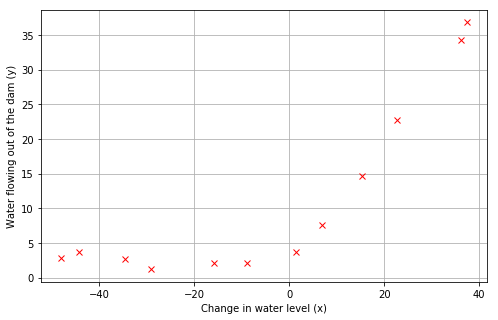

In [4]:
def plotData():
    plt.figure(figsize=(8,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X[:,1],y,'rx')
    plt.grid(True)
    
plotData()

#### 1.2 Regularized linear regression cost function

In [5]:
def h(theta,X): #Linear hypothesis function
    return np.dot(X,theta)

def computeCost(mytheta,myX,myy,mylambda=0.): #Cost function
    """
    theta_start是初始theta猜测的n维向量
    X是具有n列和m行的矩阵
    y是具有m行和1列的矩阵
    """
    m = myX.shape[0]
    myh = h(mytheta,myX).reshape((m,1))
    mycost = float((1./(2*m)) * np.dot((myh-myy).T,(myh-myy)))
    regterm = (float(mylambda)/(2*m)) * float(mytheta[1:].T.dot(mytheta[1:]))
    return mycost + regterm

In [7]:
#使用theta初始化为[1; 1]，lambda = 1，应该是303.993192的输出

mytheta = np.array([[1.],[1.]])
print(computeCost(mytheta,X,y,mylambda=1.))

303.9931922202643


#### 1.3 Regularized linear regression gradient

In [8]:
def computeGradient(mytheta,myX,myy,mylambda=0.):
    mytheta = mytheta.reshape((mytheta.shape[0],1))
    m = myX.shape[0]
    #grad has same shape as myTheta (2x1)
    myh = h(mytheta,myX).reshape((m,1))
    grad = (1./float(m))*myX.T.dot(h(mytheta,myX)-myy)
    regterm = (float(mylambda)/m)*mytheta
    regterm[0] = 0 #don't regulate bias term
    regterm.reshape((grad.shape[0],1))
    return grad + regterm

#这是computeGradient的包装器，可以平滑输出
#这是最小化程序，希望一切都变平

def computeGradientFlattened(mytheta,myX,myy,mylambda=0.):
    return computeGradient(mytheta,myX,myy,mylambda=0.).flatten()

In [10]:
#使用theta初始化为[1; 1]你应该期待看到一个
#gransion [-15.303016; 
#598.250744]（lambda = 1）

mytheta = np.array([[1.],[1.]])
print(computeGradient(mytheta,X,y,1.))

[[-15.30301567]
 [598.25074417]]


#### 1.4 Fitting linear regression

In [11]:
def optimizeTheta(myTheta_initial, myX, myy, mylambda=0.,print_output=True):
    fit_theta = scipy.optimize.fmin_cg(computeCost,x0=myTheta_initial,\
                                       fprime=computeGradientFlattened,\
                                       args=(myX,myy,mylambda),\
                                       disp=print_output,\
                                       epsilon=1.49e-12,\
                                       maxiter=1000)
    fit_theta = fit_theta.reshape((myTheta_initial.shape[0],1))
    return fit_theta

In [12]:
mytheta = np.array([[1.],[1.]])
fit_theta = optimizeTheta(mytheta,X,y,0.)

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


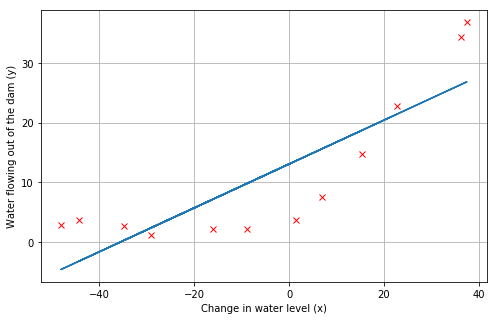

In [14]:
plotData()
plt.plot(X[:,1],h(fit_theta,X).flatten())
plt.show()

### 2 Bias-Variance

#### 2.1 Learning curves

In [17]:
def plotLearningCurve():
    """
    循环在第一个训练点，然后是前2个训练点，然后是前3个...并使用每个训练集子集来查找训练的参数。    
    使用这些参数，计算该子集的成本（Jtrain）    
    记住，对于Jtrain，lambda = 0（即使你使用正则化）。    
    然后，使用训练的参数在整个验证集上计算Jval   
    即使使用正则化，再次强制lambda = 0。    
    存储计算出的错误，error_train和error_val并绘制它们。
    """
    initial_theta = np.array([[1.],[1.]])
    mym, error_train, error_val = [], [], []
    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        fit_theta = optimizeTheta(initial_theta,train_subset,y_subset,mylambda=0.,print_output=False)
        error_train.append(computeCost(fit_theta,train_subset,y_subset,mylambda=0.))
        error_val.append(computeCost(fit_theta,Xval,yval,mylambda=0.))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)

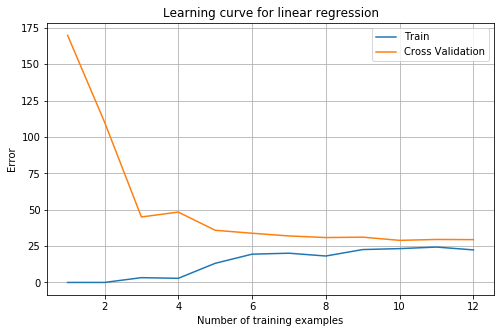

In [18]:
#“您可以观察到训练集的错误率和交叉验证错误率都很高
#当培训示例的数量增加时。这反映了很高的偏见
#模型中的问题 - 线性回归模型过于简单且无法进行
#以很好地适应我们的数据集。

plotLearningCurve()

### 3 Polynomial regression

In [19]:
def genPolyFeatures(myX,p):
    """
    函数采用X矩阵（偏差项已作为第一列包含）
    并返回带有“p”附加列的X矩阵。
    第一个附加列将是第二列（第一个非偏置列）的平方，
    下一个附加列将是第二列立方体等。
    """
    newX = myX.copy()
    for i in range(p):
        dim = i+2
        newX = np.insert(newX,newX.shape[1],np.power(newX[:,1],dim),axis=1)
    return newX

def featureNormalize(myX):
    """
    将X阵列作为输入（偏置“1”第一列），确实如此
    对列进行标准化（减去平均值，除以标准偏差）。
    返回特征规范化的X，以及列表中的特征均值和stds
    请注意，这与我在作业1中的实现不同...
    我没有意识到你应该减去手段，然后计算std
    平均减去的列。
    我发现，没有太大的区别

    """
   
    Xnorm = myX.copy()
    stored_feature_means = np.mean(Xnorm,axis=0) #column-by-column
    Xnorm[:,1:] = Xnorm[:,1:] - stored_feature_means[1:]
    stored_feature_stds = np.std(Xnorm,axis=0,ddof=1)
    Xnorm[:,1:] = Xnorm[:,1:] / stored_feature_stds[1:]
    return Xnorm, stored_feature_means, stored_feature_stds
    

#### 3.1 Learning Polynomial Regression

In [20]:
#生成一个X矩阵，其项最长为x ^ 8
#（X矩阵的7个附加列）
################################################## 
#############
#由于差异，我的d = 8剧情与作业pdf不符
#scipy.optimize.fmin_cg和八度音阶之间的＃
#我看到在subokita的实现中，为了适应他得到了
#与使用scipy.optimize.fmin_cg时的结果相同
#d = 5的情节（直到x ^ 6）显示过度拟合，所以我会
#继续使用它

###############################################################

global_d = 5
newX = genPolyFeatures(X,global_d)
newX_norm, stored_means, stored_stds = featureNormalize(newX)

# 寻找以1开头的拟合参数作为初始猜测

mytheta = np.ones((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta,newX_norm,y,0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 158
         Function evaluations: 300
         Gradient evaluations: 300


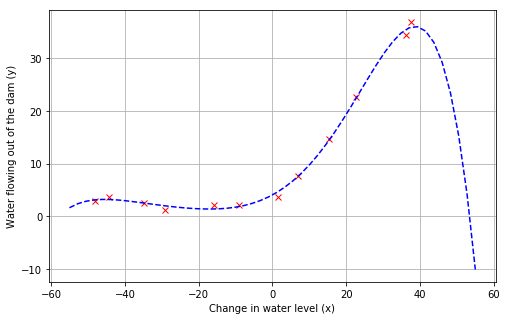

In [21]:
def plotFit(fit_theta,means,stds):
    """
    获取一些学习拟合值的函数（在特征规范化数据上）
    它将x点设置为linspace，构造一个合适的X矩阵，
    un-does先前的特征规范化，计算假设值，
    并在数据之上绘制图表
    """
    n_points_to_plot = 50
    xvals = np.linspace(-55,55,n_points_to_plot)
    xmat = np.ones((n_points_to_plot,1))
    
    xmat = np.insert(xmat,xmat.shape[1],xvals.T,axis=1)
    xmat = genPolyFeatures(xmat,len(fit_theta)-2)
    # 这是撤销特征的正则化
    xmat[:,1:] = xmat[:,1:] - means[1:]
    xmat[:,1:] = xmat[:,1:] / stds[1:]
    plotData()
    plt.plot(xvals,h(fit_theta,xmat),'b--')

plotFit(fit_theta,stored_means,stored_stds)

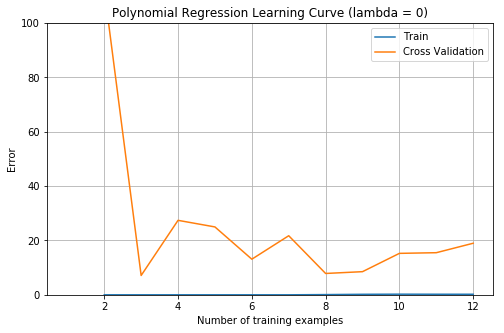

In [28]:
def plotPolyLearningCurve(mylambda=0.):

    initial_theta = np.ones((global_d+2,1))
    mym, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(Xval,global_d))

    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        mym.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset,global_d)   
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta,train_subset,y_subset,mylambda=mylambda,print_output=False)
        error_train.append(computeCost(fit_theta,train_subset,y_subset,mylambda=mylambda))
        error_val.append(computeCost(fit_theta,myXval,yval,mylambda=mylambda))
        
    plt.figure(figsize=(8,5))
    plt.plot(mym,error_train,label='Train')
    plt.plot(mym,error_val,label='Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve (lambda = 0)')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()

#### 3.2 Optional: Adjusting the regularization parameter

         Current function value: 8.042488
         Iterations: 5
         Function evaluations: 75
         Gradient evaluations: 64


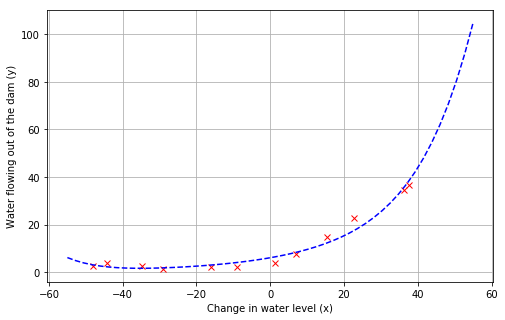

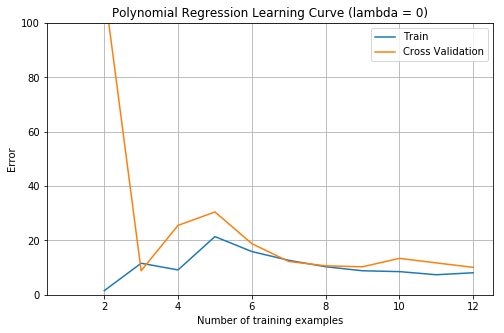

In [23]:
# 尝试Lambda = 1
mytheta = np.zeros((newX_norm.shape[1],1))
fit_theta = optimizeTheta(mytheta,newX_norm,y,1)
plotFit(fit_theta,stored_means,stored_stds)
plotPolyLearningCurve(1.)

         Current function value: 122.090023
         Iterations: 0
         Function evaluations: 41
         Gradient evaluations: 29


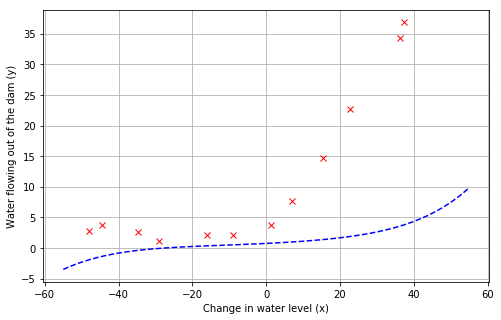

In [24]:
# 尝试Lambda = 100
# 经过一次迭代后，100的lambda很难对theta params进行惩罚
# 最小化器失去精度并放弃......
# 所以下面的图表并不表示成功

mytheta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimizeTheta(mytheta,newX_norm,y,100.)
plotFit(fit_theta,stored_means,stored_stds)

#### 3.3 Selecting $\lambda$ using a cross validation set

In [25]:
#lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]

lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = genPolyFeatures(X,global_d)
    newXtrain_norm, dummy1, dummy2 = featureNormalize(newXtrain)
    newXval = genPolyFeatures(Xval,global_d)
    newXval_norm, dummy1, dummy2 = featureNormalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimizeTheta(mytheta,newXtrain_norm,y,mylambda,False)
    errors_train.append(computeCost(fit_theta,newXtrain_norm,y,mylambda=mylambda))
    errors_val.append(computeCost(fit_theta,newXval_norm,yval,mylambda=mylambda))

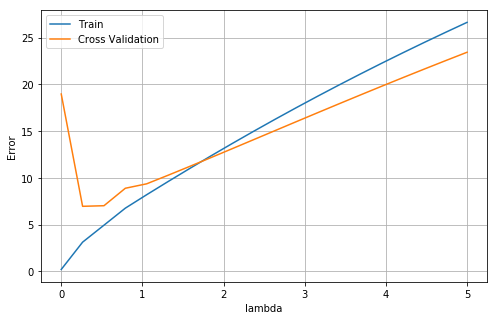

In [26]:
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)